# Autoencoders: Anomaly Detection

In [ ]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

## Data

In [ ]:
df = pd.read_csv('disk_drive_failure_dataset.csv')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [ ]:
df.head(100)

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
0,-0.951820,0.653445,-0.350397,-0.638023,0.762555,1.086045,1.071699,-0.133598,1.482903,-0.802569,1
1,-1.020026,0.547600,1.178246,-0.631427,0.942531,1.423163,0.998707,-0.223417,1.126740,-1.062854,1
2,-0.816910,0.440114,1.094353,-1.191213,1.519515,1.252360,1.067483,0.846397,0.839295,-1.230386,1
3,-0.545951,1.360774,2.256508,-0.863076,1.184116,0.930927,1.039071,-0.096000,1.060171,-1.054381,1
4,-0.546773,0.982026,0.679165,-1.051643,0.592271,1.161260,1.051465,-0.455148,1.411184,-1.124635,1
...,...,...,...,...,...,...,...,...,...,...,...
95,-1.167261,0.780502,0.277377,-1.095318,0.352426,0.841099,0.786534,0.720744,1.097019,-0.919420,0
96,-0.790441,0.631607,0.702898,-0.897967,1.522440,0.819840,1.002585,0.393166,1.540597,-1.033059,0
97,-0.380432,0.603254,0.723854,-1.096755,1.089367,1.226989,1.200305,1.959652,0.541132,-1.209229,0
98,-0.374111,1.492554,0.584258,-0.785171,0.646647,1.004076,0.925294,2.200985,1.194552,-0.880463,0


In [ ]:
y = df.iloc[:, -1]
y

0       1
1       1
2       1
3       1
4       1
       ..
5195    1
5196    1
5197    1
5198    1
5199    1
Name: V10, Length: 5200, dtype: int64

In [ ]:
X = df.iloc[:, :-1]
X

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9
0,-0.951820,0.653445,-0.350397,-0.638023,0.762555,1.086045,1.071699,-0.133598,1.482903,-0.802569
1,-1.020026,0.547600,1.178246,-0.631427,0.942531,1.423163,0.998707,-0.223417,1.126740,-1.062854
2,-0.816910,0.440114,1.094353,-1.191213,1.519515,1.252360,1.067483,0.846397,0.839295,-1.230386
3,-0.545951,1.360774,2.256508,-0.863076,1.184116,0.930927,1.039071,-0.096000,1.060171,-1.054381
4,-0.546773,0.982026,0.679165,-1.051643,0.592271,1.161260,1.051465,-0.455148,1.411184,-1.124635
...,...,...,...,...,...,...,...,...,...,...
5195,0.846620,-1.052089,-1.675128,0.947363,-1.177990,-0.716124,-0.817751,0.737901,-0.994226,0.686317
5196,0.338398,-0.323953,-1.138006,1.127649,-1.114600,-0.956082,-1.099239,-1.034257,-1.246060,0.946632
5197,0.987464,-0.132639,-1.128297,0.731082,-0.936933,-0.977299,-1.411982,-0.782215,-0.094345,1.066382
5198,1.693873,-0.085148,-0.829468,0.712778,-1.655824,-0.877840,-1.267619,-1.245702,-1.015589,0.943863


In [ ]:
from sklearn.model_selection import train_test_split

X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, 
                                                            random_state=123, stratify=y)

X_train_all.shape, X_test.shape, y_train_all.shape, y_test.shape

((4160, 10), (1040, 10), (4160,), (1040,))

In [ ]:
y_train_all.value_counts()

0    4064
1      96
Name: V10, dtype: int64

## Autoencoders

### Data Preparation for Autoencoders

In [ ]:
y_0_index = y_train_all[y_train_all==0].index

In [ ]:
y_0_index

Int64Index([1482, 1154, 3318, 4425, 4340,  810,  354, 4785, 4130,  658,
            ...
            4415, 2001,   31, 2792, 2395, 1873, 1089, 2397, 2359, 1717],
           dtype='int64', length=4064)

In [ ]:
X_train = X_train_all.loc[y_0_index]
X_train

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9
1482,-0.688712,1.045403,0.610510,-1.231521,0.971386,1.179918,0.828908,1.209652,1.405160,-1.013730
1154,-0.821781,1.520801,-0.205957,-0.989451,1.068001,1.055873,0.846924,1.478758,2.003601,-0.897238
3318,-0.566308,0.672730,0.304802,-1.029356,0.820396,0.874285,1.342577,0.458703,0.704155,-1.009795
4425,-1.020633,1.180545,1.044695,-0.479958,0.920068,0.981580,0.706985,1.455473,0.689636,-1.016259
4340,-0.547853,0.506745,0.719543,-0.764903,1.332418,1.117639,1.133174,-1.232385,0.833011,-1.068079
...,...,...,...,...,...,...,...,...,...,...
1873,-0.555118,0.762338,-0.329555,-0.899639,1.035568,0.987932,1.146700,0.708410,0.791372,-0.765236
1089,-1.185065,1.360818,-1.478395,-0.565071,1.175358,0.953142,1.191770,0.467641,0.463786,-0.770360
2397,-1.184851,0.840020,-0.592636,-1.228073,0.944523,1.185058,0.849877,-0.309598,1.351222,-1.255835
2359,-0.694728,1.206125,1.345829,-1.094960,0.909907,0.781165,0.693945,-0.460955,0.651621,-0.941161


### Model Building


In [ ]:
input_dim = X_train.shape[1]
input_dim

10

#### Model Architecture


In [ ]:
encoding_dim = 6

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(encoder)

output_layer = Dense(input_dim)(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)

autoencoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 66        
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 24        
_________________________________________________________________
dense_7 (Dense)              (None, 10)                70        
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


#### Compiling and Fitting the model

In [ ]:
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error')

In [ ]:
autoencoder.fit(X_train, X_train,
                    epochs=5,
                    batch_size=32,
                    shuffle=True,
                    verbose=1)

Epoch 1/5
127/127 [==============================] - 0s 1ms/step - loss: 0.8972
Epoch 2/5
127/127 [==============================] - 0s 1ms/step - loss: 0.5809
Epoch 3/5
127/127 [==============================] - 0s 1ms/step - loss: 0.3101
Epoch 4/5
127/127 [==============================] - 0s 2ms/step - loss: 0.2466
Epoch 5/5
127/127 [==============================] - 0s 1ms/step - loss: 0.2180


In [ ]:
predictions = autoencoder.predict(X_test)

In [ ]:
mean_square_error = np.mean(np.power(X_test - predictions, 2), axis=1)

reconstruction_error_df = pd.DataFrame({'reconstruction_error': mean_square_error,
                                        'actual_class': y_test})

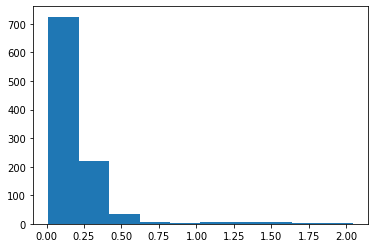

In [ ]:
# Normal cases reconstruction error plot

fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstruction_error_df[(reconstruction_error_df['actual_class']== 0) 
                      & (reconstruction_error_df['reconstruction_error'] < 50)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

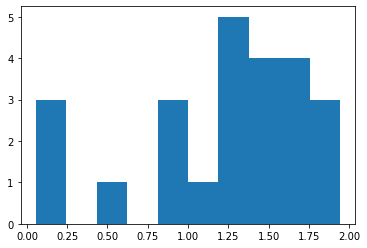

In [ ]:
# Anomaly cases reconstruction error

fig = plt.figure()
ax = fig.add_subplot(111)

anomaly_error_df = reconstruction_error_df[reconstruction_error_df['actual_class'] == 1]

_ = ax.hist(anomaly_error_df.reconstruction_error.values, bins=10)

In [ ]:
threshold = 0.5

In [ ]:
y_pred_ae = [1 if error > threshold else 0 for error in reconstruction_error_df.reconstruction_error.values]

In [ ]:
from sklearn.metrics import confusion_matrix
                            
conf_matrix = confusion_matrix(reconstruction_error_df.actual_class, y_pred_ae)
conf_matrix

array([[966,  50],
       [  3,  21]])